In this tutorial, we will go step-by-step through a simple model to distinguish different types of plankton and demonstrate some tools for exploring the image dataset. We will start by going through an example of one image to show how you could choose to develop a metric based on the shape of the object within the image. First, we import the necessary modules from scikit-image, matplotlib, scikit-learn, and numpy. If you don't currently have python installed, you can get the Anaconda distribution that includes all of the referenced packages below.

In [1]:
#Import libraries for doing image analysis
from skimage.io import imread
from skimage.transform import resize
from sklearn.ensemble import RandomForestClassifier as RF
import glob
import os
from sklearn import cross_validation
from sklearn.cross_validation import StratifiedKFold as KFold
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
from matplotlib import colors
from pylab import cm
from skimage import segmentation
from skimage.morphology import watershed
from skimage import measure
from skimage import morphology
import numpy as np
import pandas as pd
from scipy import ndimage
from skimage.feature import peak_local_max
import tensorflow as tf
from math import ceil, floor

# make graphics inline
%matplotlib inline

/home/davide/miniconda3/envs/honours/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import warnings
warnings.filterwarnings("ignore")

#### Importing the Data

The training data is organized in a series of subdirectories that contain examples for the each class of interest. We will store the list of directory names to aid in labelling the data classes for training and testing purposes.

In [3]:
# get the classnames from the directory structure
directory_names = list(set(glob.glob(os.path.join("competition_data","train_small", "*"))\
 ).difference(set(glob.glob(os.path.join("competition_data","train_small","*.*")))))

#### Preparing Training Data


In [4]:
# Rescale the images and create the combined metrics and training labels

#get the total training images
numberofImages = 0
for folder in directory_names:
    for fileNameDir in os.walk(folder):   
        for fileName in fileNameDir[2]:
             # Only read in the images
            if fileName[-4:] != ".jpg":
              continue
            numberofImages += 1
            
# We'll rescale the images to be 25x25
maxPixel = 28
imageSize = maxPixel * maxPixel
num_rows = numberofImages # one row for each image in the training dataset
num_features = imageSize # + 1 # for our ratio

# X is the feature vector with one row of features per image
# consisting of the pixel values and our metric
X = np.zeros((num_rows, num_features), dtype=float)
# y is the numeric class label 
y = np.zeros((num_rows))

files = []
# Generate training data
i = 0    
label = 0
# List of string of class names
namesClasses = list()

print("Reading images")
# Navigate through the list of directories
for folder in directory_names:
    # Append the string class name for each class
    currentClass = folder.split(os.pathsep)[-1]
    namesClasses.append(currentClass)
    for fileNameDir in os.walk(folder):   
        for fileName in fileNameDir[2]:
            # Only read in the images
            if fileName[-4:] != ".jpg":
              continue

            # Read in the images and create the features
            nameFileImage = "{0}{1}{2}".format(fileNameDir[0], os.sep, fileName)            
            image = imread(nameFileImage, as_grey=True)
            files.append(nameFileImage)
            #axisratio = getMinorMajorRatio(image)
            image = resize(image, (maxPixel, maxPixel))

            # Store the rescaled image pixels and the axis ratio
            X[i, 0:imageSize] = np.reshape(image, (1, imageSize))
            #X[i, imageSize] = axisratio

            # Store the classlabel
            y[i] = label
            i += 1
            # report progress for each 5% done  
            report = [int((j+1)*num_rows/20.) for j in range(20)]
            if i in report: 
                print (np.ceil(i *100.0 / num_rows), "% done")
    label += 1

Reading images
5.0 % done
10.0 % done
15.0 % done
20.0 % done
25.0 % done
30.0 % done
35.0 % done
40.0 % done
45.0 % done
50.0 % done
55.0 % done
60.0 % done
65.0 % done
70.0 % done
75.0 % done
80.0 % done
85.0 % done
90.0 % done
95.0 % done
100.0 % done


## Augmenting Dataset

In [5]:
IMAGE_SIZE = maxPixel

In [6]:
def flip_images(X_imgs):
    X_flip = []
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, shape = (IMAGE_SIZE, IMAGE_SIZE, 1))
    tf_img1 = tf.image.flip_left_right(X)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for img in X_imgs:
            flipped_imgs = sess.run([tf_img1], feed_dict = {X: img})
            X_flip.extend(flipped_imgs)
    X_flip = np.array(X_flip, dtype = np.float32)
    return np.concatenate((X_imgs, X_flip))

In [7]:
def rotate_images(X_imgs):
    X_rotate = []
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, shape = (IMAGE_SIZE, IMAGE_SIZE, 1))
    k = tf.placeholder(tf.int32)
    tf_img = tf.image.rot90(X, k = k)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for img in X_imgs:
            for i in range(3):  # Rotation at 90, 180 and 270 degrees
                rotated_img = sess.run(tf_img, feed_dict = {X: img, k: i + 1})
                X_rotate.append(rotated_img)
        
    X_rotate = np.array(X_rotate, dtype = np.float32)
    return np.concatenate((X_imgs, X_rotate))

In [8]:
def scale_images(X_imgs, scales=[0.80, 0.90]):
    # Various settings needed for Tensorflow operation
    boxes = np.zeros((len(scales), 4), dtype = np.float32)
    for index, scale in enumerate(scales):
        x1 = y1 = 0.5 - 0.5 * scale # To scale centrally
        x2 = y2 = 0.5 + 0.5 * scale
        boxes[index] = np.array([y1, x1, y2, x2], dtype = np.float32)
    box_ind = np.zeros((len(scales)), dtype = np.int32)
    crop_size = np.array([maxPixel, maxPixel], dtype = np.int32)
    
    X_scale_data = []
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, shape = (1, maxPixel, maxPixel, 1))
    # Define Tensorflow operation for all scales but only one base image at a time
    tf_img = tf.image.crop_and_resize(X, boxes, box_ind, crop_size)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for img_data in X_imgs:
            batch_img = np.expand_dims(img_data, axis = 0)
            scaled_imgs = sess.run(tf_img, feed_dict = {X: batch_img})
            X_scale_data.extend(scaled_imgs)
    
    X_scale_data = np.array(X_scale_data, dtype = np.float32)
    return np.concatenate((X_imgs, X_scale_data))

In [9]:
def get_translate_parameters(index):
    if index == 0: # Translate left 20 percent
        offset = np.array([0.0, 0.2], dtype = np.float32)
        size = np.array([IMAGE_SIZE, ceil(0.8 * IMAGE_SIZE)], dtype = np.int32)
        w_start = 0
        w_end = int(ceil(0.8 * IMAGE_SIZE))
        h_start = 0
        h_end = IMAGE_SIZE
    elif index == 1: # Translate right 20 percent
        offset = np.array([0.0, -0.2], dtype = np.float32)
        size = np.array([IMAGE_SIZE, ceil(0.8 * IMAGE_SIZE)], dtype = np.int32)
        w_start = int(floor((1 - 0.8) * IMAGE_SIZE))
        w_end = IMAGE_SIZE
        h_start = 0
        h_end = IMAGE_SIZE
    elif index == 2: # Translate top 20 percent
        offset = np.array([0.2, 0.0], dtype = np.float32)
        size = np.array([ceil(0.8 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
        w_start = 0
        w_end = IMAGE_SIZE
        h_start = 0
        h_end = int(ceil(0.8 * IMAGE_SIZE)) 
    else: # Translate bottom 20 percent
        offset = np.array([-0.2, 0.0], dtype = np.float32)
        size = np.array([ceil(0.8 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
        w_start = 0
        w_end = IMAGE_SIZE
        h_start = int(floor((1 - 0.8) * IMAGE_SIZE))
        h_end = IMAGE_SIZE 
        
    return offset, size, w_start, w_end, h_start, h_end

def translate_images(X_imgs):
    offsets = np.zeros((len(X_imgs), 2), dtype = np.float32)
    n_translations = 4
    X_translated_arr = []
    
    tf.reset_default_graph()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(n_translations):
            X_translated = np.zeros((len(X_imgs), IMAGE_SIZE, IMAGE_SIZE, 1), 
				    dtype = np.float32)
            X_translated.fill(1.0) # Filling background color
            base_offset, size, w_start, w_end, h_start, h_end = get_translate_parameters(i)
            offsets[:, :] = base_offset 
            glimpses = tf.image.extract_glimpse(X_imgs, size, offsets)
            
            glimpses = sess.run(glimpses)
            X_translated[:, h_start: h_start + size[0], \
			 w_start: w_start + size[1], :] = glimpses
            X_translated_arr.extend(X_translated)
    X_translated_arr = np.array(X_translated_arr, dtype = np.float32)
    return np.concatenate((X_imgs, X_translated_arr))

In [10]:
def augment_dataset(X_imgs, y_imgs):
    assert len(X_imgs) == len(y_imgs)
    X_aug = []
    y_aug = []
    i = 0
    
    for i in range(len(y_imgs)):
        
        imgs = [np.reshape(X_imgs[i,:],(IMAGE_SIZE,IMAGE_SIZE,1))]
        label = [y_imgs[i]]
        
        imgs = flip_images(imgs)
        imgs = rotate_images(imgs)
        imgs = scale_images(imgs)
        imgs = translate_images(imgs)
        
        labels = label * len(imgs)
#         print(len(labels), imgs.shape)
        
        X_aug += [np.array(x) for x in imgs.tolist()[:]]
        y_aug += labels
        
        i += 1
        # report progress for each 5% done  
        report = [int((j+1)*num_rows/20.) for j in range(20)]
        if i in report: 
            print (np.ceil(i *100.0 / num_rows), "% done")
        
    return X_aug, y_aug

In [11]:
# X_aug, y_aug = augment_dataset(X, y)

In [12]:
# X_aug = np.reshape(np.array(X_aug), (len(X_aug),imageSize))
# y_aug = np.array(y_aug)

## CNN for image classification

In [13]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.INFO)

In [14]:
N_CLASSES = len(set(y))
print(N_CLASSES)

10


In [15]:
def cnn_model_fn(features, labels, mode):
    
    """Model function for CNN."""
    # Input Layer
    # Reshape X to 4-D tensor: [batch_size, width, height, channels]
    # Plankton images are 25x25 pixels, and have one color channel
    input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

    # Convolutional Layer #1
    # Computes 32 features using a 5x5 filter with ReLU activation.
    # Padding is added to preserve width and height.
    # Input Tensor Shape: [batch_size, 28, 28, 1]
    # Output Tensor Shape: [batch_size, 28, 28, 32]
    conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

    # Pooling Layer #1
    # First max pooling layer with a 2x2 filter and stride of 2
    # Input Tensor Shape: [batch_size, 28, 28, 32]
    # Output Tensor Shape: [batch_size, 14, 14, 32]
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2
    # Computes 64 features using a 5x5 filter.
    # Padding is added to preserve width and height.
    # Input Tensor Shape: [batch_size, 14, 14, 32]
    # Output Tensor Shape: [batch_size, 14, 14, 64]
    conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

    # Pooling Layer #2
    # Second max pooling layer with a 2x2 filter and stride of 2
    # Input Tensor Shape: [batch_size, 14, 14, 64]
    # Output Tensor Shape: [batch_size, 7, 7, 64]
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Flatten tensor into a batch of vectors
    # Input Tensor Shape: [batch_size, 7, 7, 64]
    # Output Tensor Shape: [batch_size, 7 * 7 * 64]
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])

    # Dense Layer
    # Densely connected layer with 1024 neurons
    # Input Tensor Shape: [batch_size, 7 * 7 * 64]
    # Output Tensor Shape: [batch_size, 1024]
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)

    # Add dropout operation; 0.6 probability that element will be kept
    dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

    # Logits layer
    # Input Tensor Shape: [batch_size, 1024]
    # Output Tensor Shape: [batch_size, 10]
    logits = tf.layers.dense(inputs=dropout, units=N_CLASSES)

    predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)


In [16]:
#Generate indexes to shuffle dataset and create testset

idx = np.arange(len(y))
np.random.seed(seed=1234)
np.random.shuffle(idx)
separator = ceil(len(y)/10*8)
print("Train / Total: ", separator, "/", len(y))

train_data = X[idx[:separator]].astype('float32')
eval_data = X[idx[separator:]].astype('float32')
train_labels = y[idx[:separator]].astype(int)
eval_labels = y[idx[separator:]].astype(int)

train_data = train_data #[:, 0:-1] # Returns np.array, remove axis rateo feature
eval_data = eval_data #[:, 0:-1]

print("Shapes:", train_data.shape, train_labels.shape, eval_data.shape, eval_labels.shape)

Train / Total:  2373 / 2966
Shapes: (2373, 784) (2373,) (593, 784) (593,)


In [21]:
def run_experiment(train_data, train_labels, eval_data, eval_labels):
    # Create the Estimator
    image_classifier = tf.estimator.Estimator(
      model_fn=cnn_model_fn, model_dir="/tmp/image_convnet_model")

    # Set up logging for predictions
    # Log the values in the "Softmax" tensor with label "probabilities"
    tensors_to_log = {"probabilities": "softmax_tensor"}
    logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=50)

    # Train the model
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": train_data},
      y=train_labels,
      batch_size=100,
      num_epochs=None,
      shuffle=True)
    image_classifier.train(
      input_fn=train_input_fn,
      steps=10000)#,
      #hooks=[logging_hook])

    # Evaluate the model and print results
    eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": eval_data},
      y=eval_labels,
      num_epochs=1,
      shuffle=False)
    eval_results = image_classifier.evaluate(input_fn=eval_input_fn)
#     print(eval_results)
    return eval_results

In [40]:
basic_results = run_experiment(train_data, train_labels, eval_data, eval_labels)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/image_convnet_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff9b8b7d1d0>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/image_convnet_model/model.ckpt-18004
INFO:tensorflow:Saving checkpoints for 18005 into /tmp/image_convnet_model/model.ckpt.
INFO:tensorflow:loss = 1.04895, step = 18005
INFO:tensorflow:global_step/sec: 51.669
INFO:tensorflow:loss = 0.98933, step = 18105 (1.936 sec)
INFO:tensorflow:global_step/sec: 52.281
INFO:tensorflow:

INFO:tensorflow:global_step/sec: 52.8797
INFO:tensorflow:loss = 0.68804, step = 25605 (1.891 sec)
INFO:tensorflow:global_step/sec: 52.9474
INFO:tensorflow:loss = 0.746939, step = 25705 (1.889 sec)
INFO:tensorflow:global_step/sec: 52.4234
INFO:tensorflow:loss = 0.699626, step = 25805 (1.908 sec)
INFO:tensorflow:global_step/sec: 52.7663
INFO:tensorflow:loss = 0.863017, step = 25905 (1.895 sec)
INFO:tensorflow:global_step/sec: 52.4104
INFO:tensorflow:loss = 0.726468, step = 26005 (1.908 sec)
INFO:tensorflow:global_step/sec: 52.6606
INFO:tensorflow:loss = 0.657925, step = 26105 (1.899 sec)
INFO:tensorflow:global_step/sec: 52.7378
INFO:tensorflow:loss = 0.766014, step = 26205 (1.896 sec)
INFO:tensorflow:global_step/sec: 52.1248
INFO:tensorflow:loss = 0.609184, step = 26305 (1.919 sec)
INFO:tensorflow:global_step/sec: 52.4089
INFO:tensorflow:loss = 0.799613, step = 26405 (1.908 sec)
INFO:tensorflow:global_step/sec: 52.5334
INFO:tensorflow:loss = 0.873273, step = 26505 (1.903 sec)
INFO:tensor

In [19]:
train_data_AUGM, train_labels_AUGM = augment_dataset(train_data, train_labels)

5.0 % done
10.0 % done
15.0 % done
20.0 % done
25.0 % done
30.0 % done
35.0 % done
40.0 % done
45.0 % done
50.0 % done
55.0 % done
60.0 % done
65.0 % done
70.0 % done
75.0 % done
80.0 % done


In [37]:
train_data_AUGM = np.array(train_data_AUGM, dtype='float32')
train_labels_AUGM = np.array(train_labels_AUGM, dtype='int')

In [38]:
train_data_AUGM.shape

(113904, 28, 28, 1)

In [42]:
augmented_results = run_experiment(train_data_AUGM, train_labels_AUGM, eval_data, eval_labels)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/image_convnet_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ffa93527dd8>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/image_convnet_model/model.ckpt-28004
INFO:tensorflow:Saving checkpoints for 28005 into /tmp/image_convnet_model/model.ckpt.
INFO:tensorflow:loss = 0.866242, step = 28005
INFO:tensorflow:global_step/sec: 51.5884
INFO:tensorflow:loss = 0.749071, step = 28105 (1.939 sec)
INFO:tensorflow:global_step/sec: 52.4407
INFO:tensorf

INFO:tensorflow:global_step/sec: 52.5931
INFO:tensorflow:loss = 0.598958, step = 35605 (1.902 sec)
INFO:tensorflow:global_step/sec: 52.5805
INFO:tensorflow:loss = 0.983882, step = 35705 (1.901 sec)
INFO:tensorflow:global_step/sec: 52.539
INFO:tensorflow:loss = 1.21298, step = 35805 (1.904 sec)
INFO:tensorflow:global_step/sec: 52.6232
INFO:tensorflow:loss = 0.722177, step = 35905 (1.900 sec)
INFO:tensorflow:global_step/sec: 52.567
INFO:tensorflow:loss = 0.736823, step = 36005 (1.902 sec)
INFO:tensorflow:global_step/sec: 52.6842
INFO:tensorflow:loss = 0.806179, step = 36105 (1.898 sec)
INFO:tensorflow:global_step/sec: 52.5846
INFO:tensorflow:loss = 0.720394, step = 36205 (1.902 sec)
INFO:tensorflow:global_step/sec: 52.6674
INFO:tensorflow:loss = 0.765246, step = 36305 (1.898 sec)
INFO:tensorflow:global_step/sec: 52.6163
INFO:tensorflow:loss = 0.819428, step = 36405 (1.901 sec)
INFO:tensorflow:global_step/sec: 52.6368
INFO:tensorflow:loss = 0.875851, step = 36505 (1.900 sec)
INFO:tensorfl

In [43]:
print("BASIC RESULTS: ", basic_results)
print("AUGMENTED RESULTS: ", augmented_results)

BASIC RESULTS:  {'accuracy': 0.73355818, 'loss': 0.78395879, 'global_step': 28004}
AUGMENTED RESULTS:  {'accuracy': 0.70320404, 'loss': 0.85364974, 'global_step': 38004}


#### Width-to-Length Ratio Class Separation

Now that we have calculated the width-to-length ratio metric for all the images, we can look at the class separation to see how well our feature performs. We'll compare pairs of the classes' distributions by plotting each pair of classes. While this will not cover the whole space of hundreds of possible combinations, it will give us a feel for how similar or dissimilar different classes are in this feature, and the class distributions should be comparable across subplots.



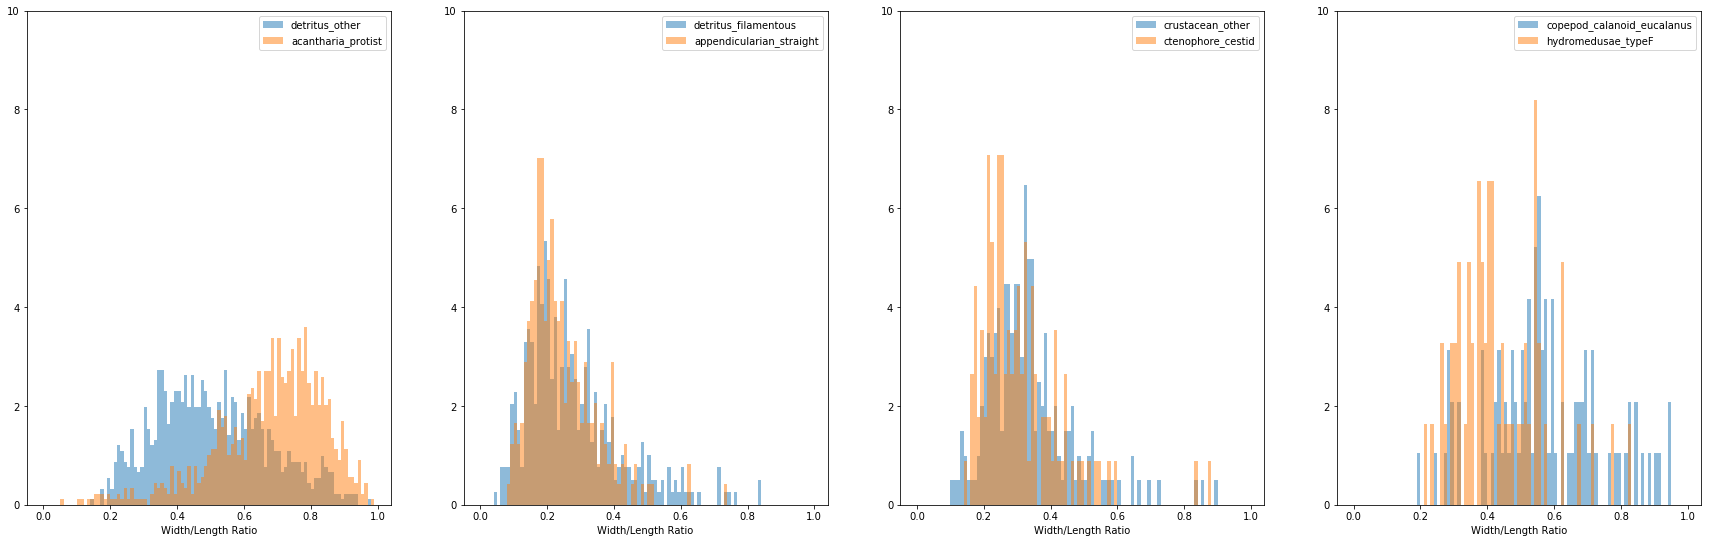

In [30]:
# Loop through the classes two at a time and compare their distributions of the Width/Length Ratio

#Create a DataFrame object to make subsetting the data on the class 
df = pd.DataFrame({"class": y[:], "ratio": X[:, num_features-1]})

f = plt.figure(figsize=(30, 20))
#we suppress zeros and choose a few large classes to better highlight the distributions.
df = df.loc[df["ratio"] > 0]
minimumSize = 20 
counts = df["class"].value_counts()
largeclasses = [int(x) for x in list(counts.loc[counts > minimumSize].index)]
# Loop through 40 of the classes 
for j in range(0,8,2):
    subfig = plt.subplot(2, 4, j/2 +1)
    # Plot the normalized histograms for two classes
    classind1 = largeclasses[j]
    classind2 = largeclasses[j+1]
    n, bins,p = plt.hist(df.loc[df["class"] == classind1]["ratio"].values,\
                         alpha=0.5, bins=[x*0.01 for x in range(100)], \
                         label=namesClasses[classind1].split(os.sep)[-1], normed=1)

    n2, bins,p = plt.hist(df.loc[df["class"] == (classind2)]["ratio"].values,\
                          alpha=0.5, bins=bins, label=namesClasses[classind2].split(os.sep)[-1],normed=1)
    subfig.set_ylim([0.,10.])
    plt.legend(loc='upper right')
    plt.xlabel("Width/Length Ratio")

### Plots with Augmented Dataset

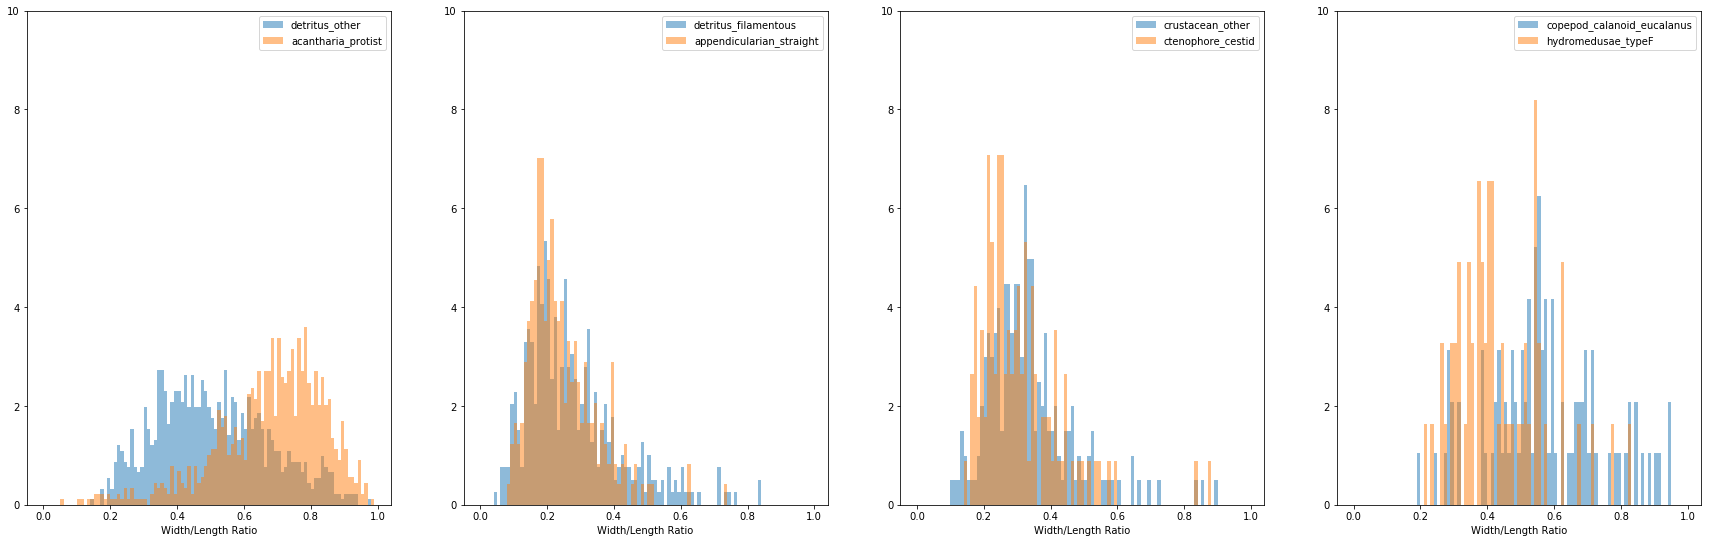

In [32]:
# Loop through the classes two at a time and compare their distributions of the Width/Length Ratio

#Create a DataFrame object to make subsetting the data on the class 
df = pd.DataFrame({"class": y_aug[:], "ratio": X_aug[:, num_features-1]})

f = plt.figure(figsize=(30, 20))
#we suppress zeros and choose a few large classes to better highlight the distributions.
df = df.loc[df["ratio"] > 0]
minimumSize = 20 
counts = df["class"].value_counts()
largeclasses = [int(x) for x in list(counts.loc[counts > minimumSize].index)]
# Loop through 40 of the classes 
for j in range(0,8,2):
    subfig = plt.subplot(2, 4, j/2 +1)
    # Plot the normalized histograms for two classes
    classind1 = largeclasses[j]
    classind2 = largeclasses[j+1]
    n, bins,p = plt.hist(df.loc[df["class"] == classind1]["ratio"].values,\
                         alpha=0.5, bins=[x*0.01 for x in range(100)], \
                         label=namesClasses[classind1].split(os.sep)[-1], normed=1)

    n2, bins,p = plt.hist(df.loc[df["class"] == (classind2)]["ratio"].values,\
                          alpha=0.5, bins=bins, label=namesClasses[classind2].split(os.sep)[-1],normed=1)
    subfig.set_ylim([0.,10.])
    plt.legend(loc='upper right')
    plt.xlabel("Width/Length Ratio")

From the (truncated) figure above, you will see some cases where the classes are well separated and others were they are not. It is typical that one single feature will not allow you to completely separate more than thirty distinct classes. You will need to be creative in coming up with additional metrics to discriminate between all the classes.

#### Random Forest Classification

We choose a random forest model to classify the images. Random forests perform well in many classification tasks and have robust default settings. We will give a brief description of a random forest model so that you can understand its two main free parameters: n_estimators and max_features.

A random forest model is an ensemble model of n_estimators number of decision trees. During the training process, each decision tree is grown automatically by making a series of conditional splits on the data. At each split in the decision tree, a random sample of max_features number of features is chosen and used to make a conditional decision on which of the two nodes that the data will be grouped in. The best condition for the split is determined by the split that maximizes the class purity of the nodes directly below. The tree continues to grow by making additional splits until the leaves are pure or the leaves have less than the minimum number of samples for a split (in sklearn default for min_samples_split is two data points). The final majority class purity of the terminal nodes of the decision tree are used for making predictions on what class a new data point will belong. Then, the aggregate vote across the forest determines the class prediction for new samples.

With our training data consisting of the feature vector X and the class label vector y, we will now calculate some class metrics for the performance of our model, by class and overall. First, we train the random forest on all the available data and let it perform the 5-fold cross validation. Then we perform the cross validation using the KFold method, which splits the data into train and test sets, and a classification report. The classification report provides a useful list of performance metrics for your classifier vs. the internal metrics of the random forest module.



In [33]:
print("Training")
# n_estimators is the number of decision trees
# max_features also known as m_try is set to the default value of the square root of the number of features
clf = RF(n_estimators=100, n_jobs=3);
scores = cross_validation.cross_val_score(clf, X, y, cv=5, n_jobs=1);
print("Accuracy of all classes")
print(np.mean(scores))

Training
Accuracy of all classes
0.716075599594


In [34]:
kf = KFold(y, n_folds=5)
y_pred = y * 0
for train, test in kf:
    X_train, X_test, y_train, y_test = X[train,:], X[test,:], y[train], y[test]
    clf = RF(n_estimators=100, n_jobs=3)
    clf.fit(X_train, y_train)
    y_pred[test] = clf.predict(X_test)
print(classification_report(y, y_pred, target_names=namesClasses))

                                                               precision    recall  f1-score   support

                  competition_data/train_small/detritus_other       0.63      0.90      0.75       914
              competition_data/train_small/hydromedusae_typeF       0.80      0.61      0.69        61
competition_data/train_small/ctenophore_cydippid_no_tentacles       0.00      0.00      0.00        42
      competition_data/train_small/copepod_calanoid_eucalanus       0.97      0.38      0.54        96
            competition_data/train_small/detritus_filamentous       0.54      0.46      0.50       394
              competition_data/train_small/hydromedusae_typeE       0.00      0.00      0.00        14
               competition_data/train_small/ctenophore_cestid       1.00      0.08      0.15       113
                competition_data/train_small/crustacean_other       0.75      0.63      0.68       201
        competition_data/train_small/appendicularian_straight       0.69

The current model, while somewhat accurate overall, doesn't do well for all classes, including the shrimp caridean, stomatopod, or hydromedusae tentacles classes. For others it does quite well, getting many of the correct classifications for trichodesmium_puff and copepod_oithona_eggs classes. The metrics shown above for measuring model performance include precision, recall, and f1-score. The precision metric gives probability that a chosen class is correct, (true positives / (true positive + false positives)), while recall measures the ability of the model correctly classify examples of a given class, (true positives / (false negatives + true positives)). The F1 score is the geometric average of the precision and recall.

The competition scoring uses a multiclass log-loss metric to compute your overall score. In the next steps, we define the multiclass log-loss function and compute your estimated score on the training dataset.

In [35]:
def multiclass_log_loss(y_true, y_pred, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    https://www.kaggle.com/wiki/MultiClassLogLoss

    Parameters
    ----------
    y_true : array, shape = [n_samples]
            true class, intergers in [0, n_classes - 1)
    y_pred : array, shape = [n_samples, n_classes]

    Returns
    -------
    loss : float
    """
    predictions = np.clip(y_pred, eps, 1 - eps)

    # normalize row sums to 1
    predictions /= predictions.sum(axis=1)[:, np.newaxis]

    actual = np.zeros(y_pred.shape)
    n_samples = actual.shape[0]
    actual[np.arange(n_samples), y_true.astype(int)] = 1
    vectsum = np.sum(actual * np.log(predictions))
    loss = -1.0 / n_samples * vectsum
    return loss

In [36]:
# Get the probability predictions for computing the log-loss function
kf = KFold(y, n_folds=5)
# prediction probabilities number of samples, by number of classes
y_pred = np.zeros((len(y),len(set(y))))
for train, test in kf:
    X_train, X_test, y_train, y_test = X[train,:], X[test,:], y[train], y[test]
    clf = RF(n_estimators=100, n_jobs=3)
    clf.fit(X_train, y_train)
    y_pred[test] = clf.predict_proba(X_test)

In [37]:
multiclass_log_loss(y, y_pred)

0.96844833753168413

In [45]:
y.shape

(2966,)

## Evaluation with augmented dataset

In [48]:
print("Training")
# n_estimators is the number of decision trees
# max_features also known as m_try is set to the default value of the square root of the number of features
clf = RF(n_estimators=100, n_jobs=3);
scores = cross_validation.cross_val_score(clf, X_aug, y_aug, cv=5, n_jobs=1);
print("Accuracy of all classes")
print(np.mean(scores))

Training
Accuracy of all classes
0.742152463304


In [38]:
# Get the probability predictions for computing the log-loss function
kf = KFold(y_aug, n_folds=5)
# prediction probabilities number of samples, by number of classes
y_aug_pred = np.zeros((len(y_aug),len(set(y_aug))))
for train, test in kf:
    X_train, X_test, y_train, y_test = X_aug[train,:], X_aug[test,:], y_aug[train], y_aug[test]
    clf = RF(n_estimators=100, n_jobs=3)
    clf.fit(X_train, y_train)
    y_aug_pred[test] = clf.predict_proba(X_test)

In [40]:
multiclass_log_loss(y_aug, y_aug_pred)

0.83528301329128241

In [41]:
print(classification_report(y_aug, y_aug_pred, target_names=namesClasses))

ValueError: Mix type of y not allowed, got types {'continuous-multioutput', 'multiclass'}

In [47]:
y_aug_pred.shape

(142368, 10)

The multiclass log loss function is an classification error metric that heavily penalizes you for being both confident (either predicting very high or very low class probability) and wrong. Throughout the competition you will want to check that your model improvements are driving this loss metric lower.

#### Where to Go From Here

Now that you've made a simple metric, created a model, and examined the model's performance on the training data, the next step is to make improvements to your model to make it more competitive. The random forest model we created does not perform evenly across all classes and in some cases fails completely. By creating new features and looking at some of your distributions for the problem classes directly, you can identify features that specifically help separate those classes from the others. You can add new metrics by considering other image properties, stratified sampling, transformations, or other models for the classification.

Shapes: (2373, 626) (593, 626) (2373,) (593,)


In [43]:
len(y_test)

593

In [57]:
 len(set(train_labels))

10

In [77]:
type(train_data[0,0])

numpy.float32